<a href="https://colab.research.google.com/github/sultan-hassan/tutorials/blob/main/NF_UVLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyro-ppl corner smt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for smt: filename=smt-2.0-cp310-cp310-linux_x86_64.whl size=672653 sha256=4682c777298b2daece2cf6b9faf6c9d771a69702a1a339ba4136eb3433ab1b54
  Stored in directory: /root/.cache/pip/wheels/c0/f0/58/98644c8bef7a61927a3835b3fa22d9e09a5bdc53f6505807b6
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25521 sha256=ae6f8dbc4b89e9e0028249d9948c06ea4d65fc8db3ab7490a8f5d9ab6fa9b03f
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built smt pyDOE2


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from smt.sampling_methods import LHS
import matplotlib.colors as colors
import corner
import random

In [4]:
def schechter(magnitude, phiStar, alpha, MStar):
  """Schechter luminosity function by magnitudes."""
  MStarMinM = 0.4 * (MStar - magnitude)
  return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

In [5]:
# set the magnitude range

mag_min, mag_max, dmag = -17, -22, 0.5
magnitude = np.arange(mag_max,mag_min,dmag)

In [6]:
magnitude

array([-22. , -21.5, -21. , -20.5, -20. , -19.5, -19. , -18.5, -18. ,
       -17.5])

In [7]:
# check a random the LF
phiStar, alpha, MStar = 1e-4, -2., -20.
LF = schechter(magnitude,phiStar, alpha, MStar )

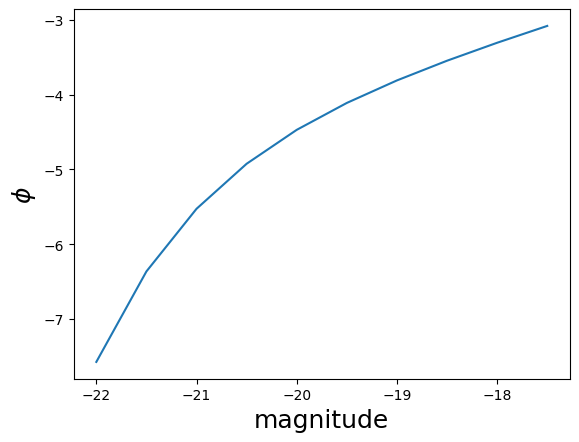

In [8]:
plt.plot(magnitude, np.log10(LF))
plt.xlabel("magnitude",fontsize=18)
plt.ylabel(r"$\phi$", fontsize=18)
plt.show()

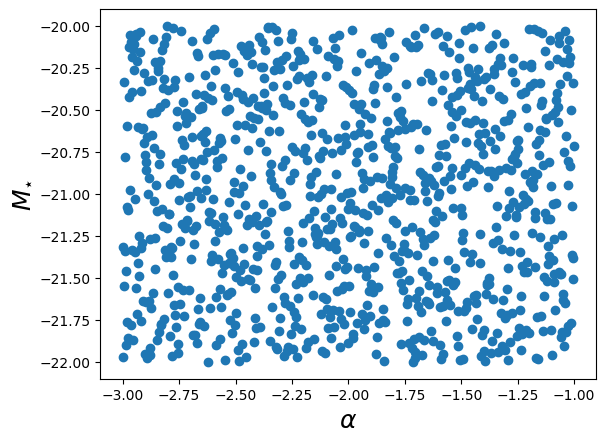

In [9]:
# generate a training set over some prior range using latin-hypercube sampling (LHS) in alpha - Mstar plane
prior_alpha = [-3., -1.]
prior_Mstar = [-22, -20]
xlimits     =  np.array([prior_alpha, prior_Mstar])
sampling    = LHS(xlimits=xlimits)
num         = 1000   # total number of samples
y_train     = sampling(num)
plt.plot(y_train[:, 0], y_train[:, 1], "o")
plt.xlabel(r"$\alpha$",fontsize=18)
plt.ylabel(r"$M_{\star}$",fontsize=18)
plt.show()


In [10]:
data_dim = len(magnitude)
x_train = np.zeros((num,data_dim))
for i in range(num):
  x_train[i] = np.log10(schechter(magnitude,phiStar, y_train[i, 0], y_train[i, 1] ))

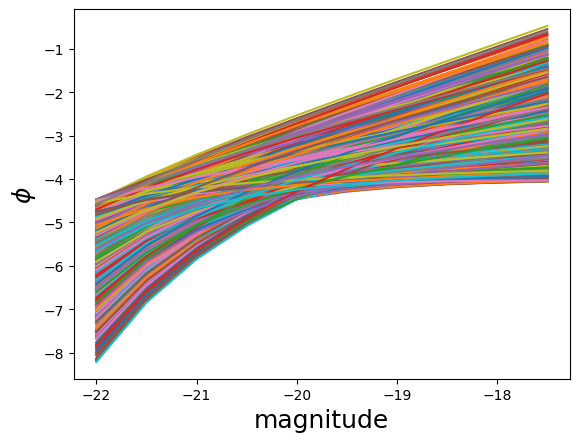

In [11]:
for i in range(num):
    plt.plot(magnitude, x_train[i])
plt.xlabel("magnitude",fontsize=18)
plt.ylabel(r"$\phi$", fontsize=18)
plt.show()

In [12]:
# common practice to standarize the data to a zero mean and unit variance
x_train  -= np.mean(x_train)
x_train   /= np.std(x_train)


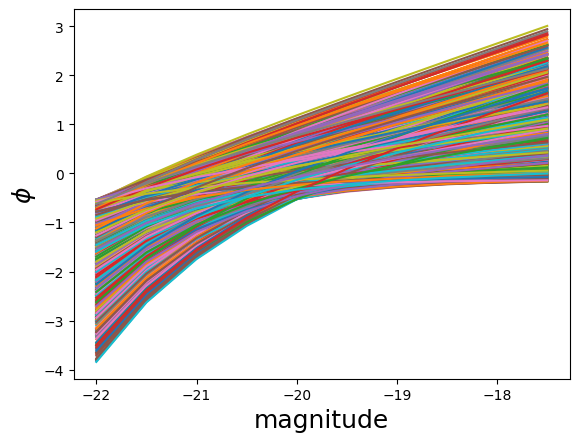

In [13]:
for i in range(num):
    plt.plot(magnitude, x_train[i])
plt.xlabel("magnitude",fontsize=18)
plt.ylabel(r"$\phi$", fontsize=18)
plt.show()

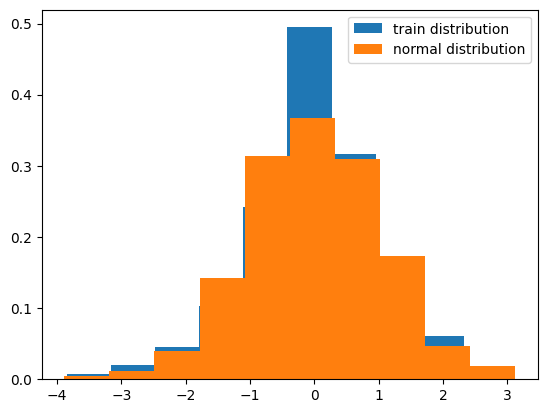

In [14]:
# test against normal distribution

plt.hist(x_train.flatten(), density=True, label='train distribution')
plt.hist(np.random.normal(0,1, (num)),density=True, label='normal distribution')
plt.legend()
plt.show()

In [15]:
# common practice to nomalize the labels from 0 to 1
label_dim = y_train.shape[1]
for i in range(label_dim):
    print ( "min and max before normalizing>>>", i, y_train[:,i].min() ,  y_train[:,i].max())

    y_train[:,i] = (y_train[:,i] - y_train[:,i].min())/(y_train[:,i].max() - y_train[:,i].min())

    print ( "min and max after normalizing>>>", i, y_train[:,i].min(),   y_train[:,i].max())

min and max before normalizing>>> 0 -2.999 -1.001
min and max after normalizing>>> 0 0.0 1.0
min and max before normalizing>>> 1 -21.999 -20.001
min and max after normalizing>>> 1 0.0 1.0


In [16]:
# define the base distribution
dist_base = dist.Normal(torch.zeros(data_dim), torch.ones(data_dim))
# define spline transformation
LF_transform = T.spline(data_dim)
# apply transform on the distribution
dist_LF      = dist.TransformedDistribution(dist_base, [LF_transform])
# define conditional spline transformation
param_transform = T.conditional_spline(data_dim, context_dim=label_dim)
# apply the conditional transformation
dist_LF_given_param = dist.ConditionalTransformedDistribution(dist_base, [param_transform])
# store learnable transforms in a list to update during training
modules = torch.nn.ModuleList([LF_transform,param_transform])


In [17]:
# pass data to loader for mini-batch training

X_data = torch.tensor(x_train, dtype=torch.float32)
Y_data = torch.tensor(y_train, dtype=torch.float32)
train_dataloader = DataLoader(list(zip(X_data, Y_data)), batch_size=32,  shuffle=True)

In [18]:
%%time
# "training loop"
steps = 1000
optimizer = torch.optim.Adam(modules.parameters(), lr=0.001) # optimizer
for step in range(steps):
    train_loss = 0
    for i, (batch_x, batch_y) in enumerate(train_dataloader): # loop through mini-batch
        optimizer.zero_grad()
        ln_p_LF             = dist_LF.log_prob(batch_x) # probability of LF (batch_x)
        ln_p_LF_given_param = dist_LF_given_param.condition(batch_y.detach()).log_prob(batch_x.detach()) #  probability of LF (batch_x) given params (batch_y)
        loss = -(ln_p_LF + ln_p_LF_given_param).mean() # total loss (sum of probabilities)
        loss.backward() # apply backpropagation computing the gradient of the loss w.r.t weights/biases
        optimizer.step() # update the weights/biases
        dist_LF.clear_cache() # release all memory
        dist_LF_given_param.clear_cache()  # release all memory
        train_loss += loss.item() # store all loss from mini-batch

    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, train_loss/(i+1)))

step: 0, loss: 4.6931130439043045
step: 100, loss: -2.404384918510914
step: 200, loss: -2.6175475418567657
step: 300, loss: -2.649407021701336
step: 400, loss: -2.763979271054268
step: 500, loss: -2.7813081219792366
step: 600, loss: -2.8867591619491577
step: 700, loss: -3.0200717449188232
step: 800, loss: -3.2765074372291565
step: 900, loss: -3.197454944252968
CPU times: user 7min 39s, sys: 1.07 s, total: 7min 40s
Wall time: 7min 54s


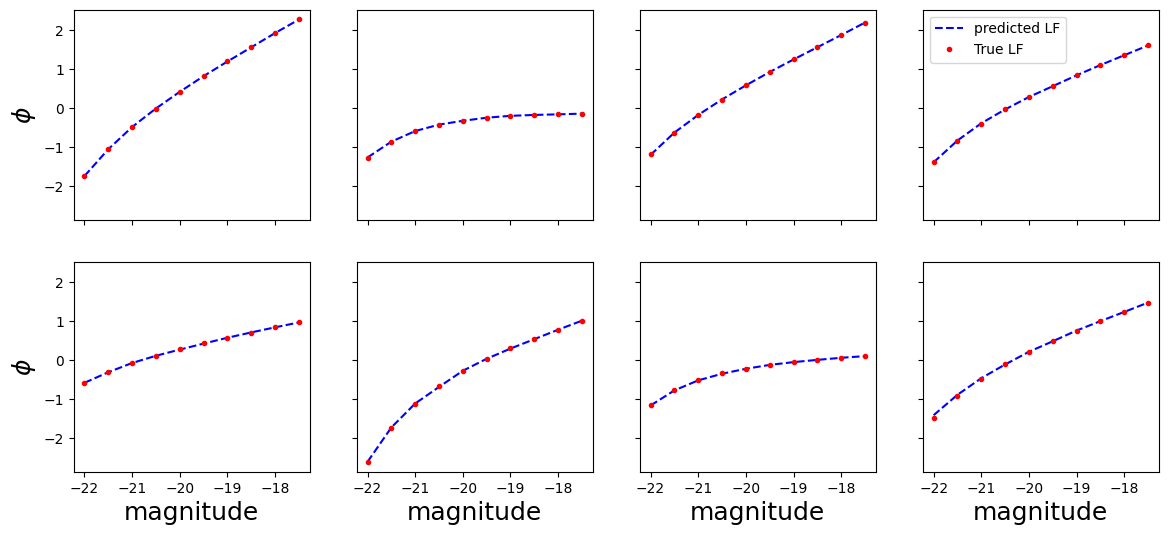

In [24]:
# Emulation, random realizations from the training set

ind = np.random.randint(0, num, 8)

fig, ax = plt.subplots(2,4, sharey=True, sharex=True, figsize=(14,6))
n = 0
for i in range(2):
  ax[i,0].set_ylabel(r"$\phi$", fontsize=18)
  for j in range(4):
    ax[i,j].plot(magnitude, dist_LF_given_param.condition(Y_data[ind[n]]).sample().detach().numpy(), 'b--', label='predicted LF')
    ax[i,j].plot(magnitude, X_data.detach().numpy()[ind[n]], 'r.', label='True LF')
    ax[1,j].set_xlabel("magnitude", fontsize=18)
    n+=1
ax[0,3].legend()
plt.show()

In [33]:
# good now the model has learned the probability of the LF given the parameters === the likelihood for free! Since the prior is uniform, likelihood ~ posterior!

#Pick_up a mock LF from 0 to 1000 total number of samples

ind_s = 630

x_mock = X_data[ind_s]
y_mock = Y_data[ind_s]

# compute the probability of the mock LF given the true mock parameters

mock_prob  = dist_LF_given_param.condition(y_mock).log_prob(x_mock).mean().detach().numpy()

print (mock_prob)

4.505648


In [34]:
# generate new samples over the prior range, to observe some noise maybe 1e4 samples enough!
num_sam      = 1000
y_sample     = sampling(num_sam)
for i in range(label_dim):
    print ( "min and max before normalizing>>>", i, y_sample[:,i].min() ,  y_sample[:,i].max())

    y_sample[:,i] = (y_sample[:,i] - y_sample [:,i].min())/(y_sample[:,i].max() - y_sample[:,i].min())

    print ( "min and max after normalizing>>>", i, y_sample[:,i].min(),   y_sample[:,i].max())

min and max before normalizing>>> 0 -2.999 -1.001
min and max after normalizing>>> 0 0.0 1.0
min and max before normalizing>>> 1 -21.999 -20.001
min and max after normalizing>>> 1 0.0 1.0


In [35]:
# compute all probability of the mock LF over the entire set of the new parameters

y_sample = torch.tensor(y_sample, dtype=torch.float32)

mock_prob_all   = torch.zeros(num_sam)
for i in range(num_sam):
    mock_prob_all[i] = dist_LF_given_param.condition(y_sample[i]).log_prob(x_mock).mean()

mock_prob_all = mock_prob_all.detach().numpy()
y_sample      = y_sample.detach().numpy()

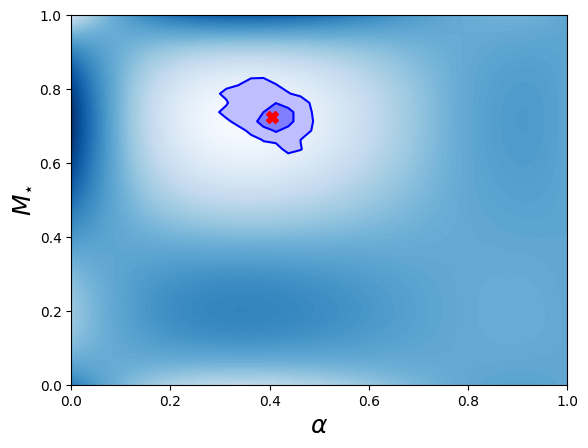

In [36]:
# normalize all probabilities
prob_norm  = np.exp(mock_prob_all - np.max(mock_prob_all))
# smooth bivariant spline
sbs        = interpolate.SmoothBivariateSpline(y_sample[:,0],y_sample[:,1], prob_norm, kx=3,ky=3)
# generate mesh
xi, yi     = np.meshgrid(np.linspace(y_sample[:,0].min(), y_sample[:,0].max(), num_sam) , np.linspace(y_sample[:,1].min(), y_sample[:,1].max(), num_sam) )
zi         = sbs.ev(xi, yi)
# show the smoothed probabilities
plt.contourf(xi, yi, zi, 100, cmap='Blues_r')#, norm=colors.SymLogNorm(linthresh=0.1))
# plot contours
corner.hist2d(y_sample[:,0],y_sample[:,1], bins=40, weights=prob_norm, plot_datapoints=False,plot_density=False,
                              smooth=0.5, levels=[0.393,0.865, 0.989],fill_contours=True, color='b', alpha=0.2)
# plot the mock
plt.plot(y_mock[0],y_mock[1], 'X', color='r', ms=8)

# labels
plt.xlabel(r"$\alpha$",fontsize=18)
plt.ylabel(r"$M_{\star}$",fontsize=18)
plt.show()